In [1]:
# Import required dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.insert(0, parent_dir)

# Configure matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# constants
FIGURE_SAVE_LOCATION = "../data/figures/05evaluate/"
FIGURE_PREFILE = "outer_"

In [2]:
# Load batch data

batch_dir = "../data/outer/batch"
batch_data = {}

# for each folder in the batch directory
for folder in os.listdir(batch_dir):
    folder_path = os.path.join(batch_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": folder_name_parts[0],
            "iteration": folder_name_parts[1],
            "runs": folder_name_parts[2],
            "timestamps_data": {},
            "trial_data": {}
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the batch_data dictionary
        batch_data[folder] = data

In [3]:
# print root elements of batch_data
for key, value in batch_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

8_20_10: 8, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

16_20_10: 16, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

1_20_10: 1, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

2_20_10: 2, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

4_20_10: 4, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']



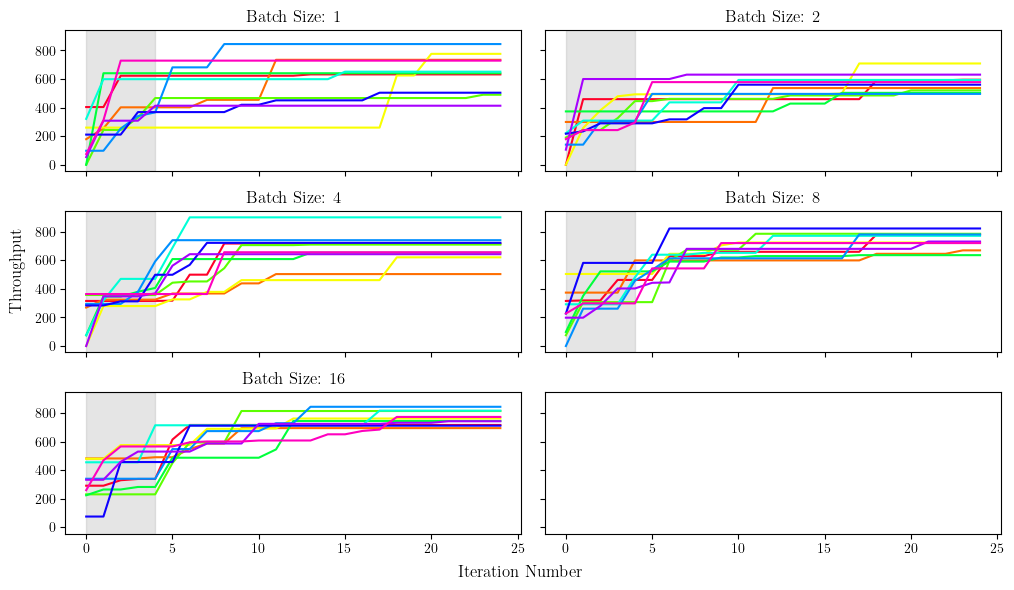

In [4]:
# Plot each batch in a separate subplot (each trial)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

# Create a 2x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)

# sort the batch_data by int
batch_data = dict(sorted(batch_data.items(), key=lambda item: int(item[1]['batch'])))

for i, (batch_name, data) in enumerate(batch_data.items()):
    ax = axes[i // 2, i % 2]

    # For each trial in trial_data, plot the max‐per‐trial throughput for each run
    for trial_name, trial_df in data["trial_data"].items():
        # extract the trial index from the trial_df
        best_per_trial = (
            trial_df
            .groupby("trial_index")["inv_rho_inc"]
            .max()
            .reset_index()
        )
        ax.plot(
            best_per_trial["trial_index"],
            best_per_trial["inv_rho_inc"],
            label=trial_name
        )
    ax.set_title(f"Batch Size: {data['batch']}")

    # Shade warmup trials 0-4
    ax.axvspan(0.0, 4.0, color='gray', alpha=0.2, label='Warm Start (Trials 0–4)')


# Add shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}batch.pdf", bbox_inches='tight')

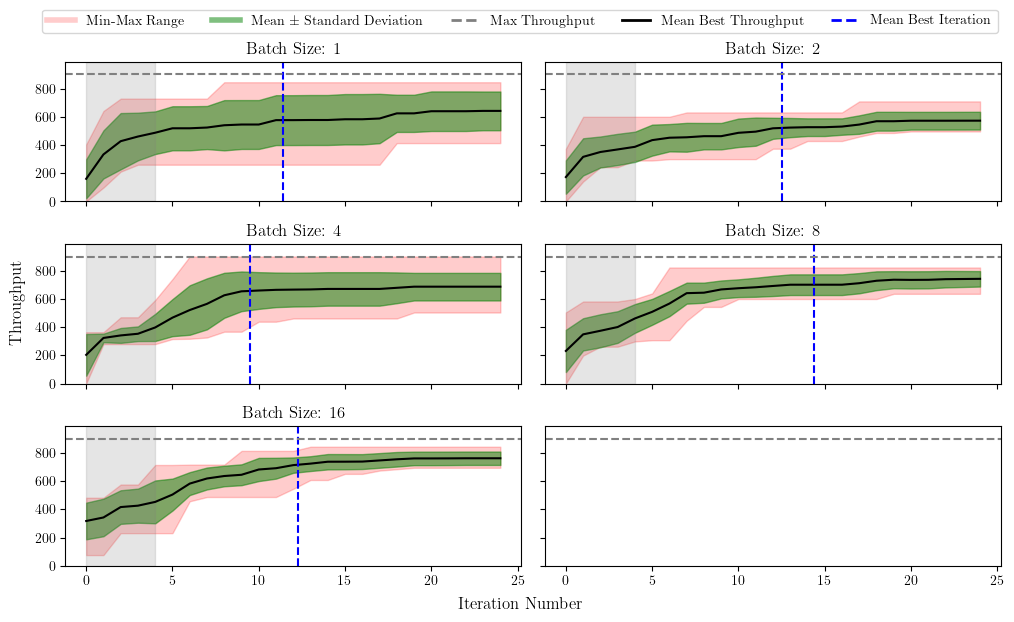

In [5]:
# Plot each batch in a separate subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)

# sort the batch_data by batch size
batch_data = dict(sorted(batch_data.items(), key=lambda item: int(item[1]['batch'])))

# find the maximum inv_rho_inc across all trials and batches
max_rho = 0.0

for i, (batch_name, data) in enumerate(batch_data.items()):
    ax = axes[i // 2, i % 2]

    # concatenate all trials, then compute mean and std of inv_rho_inc by trial_index
    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current batch has a higher max inv_rho_inc
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')
    
    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )
    
    ax.set_title(f"Batch Size: {data['batch']}")

    # Shade warmup trials 0-4
    ax.axvspan(0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes.flat:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)  # set y-limits to 10% above max_rho

# shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.00))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}batch_error_area.pdf", bbox_inches='tight')

In [6]:
# for batch size 16, print the max inv_rho_inc
best_configs = []
for batch_name, data in batch_data.items():
    if data['batch'] == '16':
        for trial_name, trial_df in data["trial_data"].items():
            best_row = trial_df.loc[trial_df['inv_rho_inc'].idxmax()]
            details = best_row.filter(regex='^(num_islands_|skew_exponent_)')
            details_str = ', '.join(f"{k}: {v}" for k, v in details.items())
            print(f"Trial: {trial_name}, Max inv_rho_inc: {trial_df['inv_rho_inc'].max()}, {details_str}")

            best_configs.append({
                "trial_name": trial_name,
                "max_inv_rho_inc": trial_df['inv_rho_inc'].max(),
                **details.to_dict()
            })


Trial: 7, Max inv_rho_inc: 716.5576409186868, num_islands_DGX-B300: 13, skew_exponent_DGX-B300: 1.0749994066992428, num_islands_H200: 121, skew_exponent_H200: 5.0
Trial: 6, Max inv_rho_inc: 694.4004424393607, num_islands_DGX-B300: 48, skew_exponent_DGX-B300: -1.2907007463346545, num_islands_H200: 29, skew_exponent_H200: 3.211072472161114
Trial: 4, Max inv_rho_inc: 761.6284566106287, num_islands_DGX-B300: 17, skew_exponent_DGX-B300: 1.0275243888416687, num_islands_H200: 128, skew_exponent_H200: -2.8537724312256696
Trial: 5, Max inv_rho_inc: 814.130752885279, num_islands_DGX-B300: 21, skew_exponent_DGX-B300: 2.89655412207131, num_islands_H200: 128, skew_exponent_H200: 4.239478682709143
Trial: 1, Max inv_rho_inc: 744.2340359743531, num_islands_DGX-B300: 11, skew_exponent_DGX-B300: 1.183073585761106, num_islands_H200: 128, skew_exponent_H200: -4.4262746310005685
Trial: 2, Max inv_rho_inc: 816.6844020511643, num_islands_DGX-B300: 25, skew_exponent_DGX-B300: 5.0, num_islands_H200: 106, skew_

In [7]:
# for batch size 16, print the max inv_rho_inc
configs = []
for batch_name, data in batch_data.items():
    if data['batch'] == '16':
        for trial_name, trial_df in data["trial_data"].items():
            for index, row in trial_df.iterrows():
                details = row.filter(regex='^(num_islands_|skew_exponent_)')
                details_str = ', '.join(f"{k}: {v}" for k, v in details.items())
                print(f"Trial: {trial_name}, Max inv_rho_inc: {trial_df['inv_rho_inc'].max()}, {details_str}")

                configs.append({
                    "trial_name": trial_name,
                    "max_inv_rho_inc": trial_df['inv_rho_inc'].max(),
                    **details.to_dict()
                })


Trial: 7, Max inv_rho_inc: 716.5576409186868, num_islands_DGX-B300: 2, skew_exponent_DGX-B300: -0.7974493461521615, num_islands_H200: 58, skew_exponent_H200: 4.268573822532732
Trial: 7, Max inv_rho_inc: 716.5576409186868, num_islands_DGX-B300: 29, skew_exponent_DGX-B300: -2.975770316111804, num_islands_H200: 92, skew_exponent_H200: 3.914046775080047
Trial: 7, Max inv_rho_inc: 716.5576409186868, num_islands_DGX-B300: 36, skew_exponent_DGX-B300: -4.639340370939128, num_islands_H200: 63, skew_exponent_H200: -4.396631851533991
Trial: 7, Max inv_rho_inc: 716.5576409186868, num_islands_DGX-B300: 15, skew_exponent_DGX-B300: -2.4510876397753822, num_islands_H200: 97, skew_exponent_H200: 2.5738016566965687
Trial: 7, Max inv_rho_inc: 716.5576409186868, num_islands_DGX-B300: 13, skew_exponent_DGX-B300: 1.9312717209141643, num_islands_H200: 20, skew_exponent_H200: -2.3429160158817144
Trial: 7, Max inv_rho_inc: 716.5576409186868, num_islands_DGX-B300: 45, skew_exponent_DGX-B300: -5.0, num_islands_H

/var/folders/y0/2k6mgl4x5_db4cbjlvjsc0jw0000gn/T/ipykernel_74846/2715303697.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


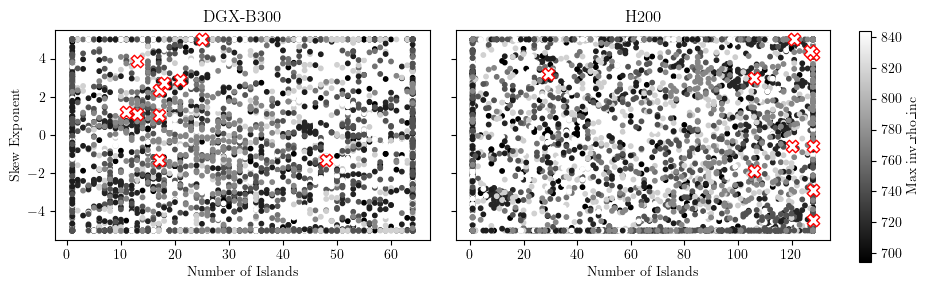

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual DataFrames
configs_df      = pd.DataFrame(configs)
best_configs_df = pd.DataFrame(best_configs)

# Base marker size for the cloud of all configs
base_size = 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# --- DGX-B300 subplot (all configs) ---
sc1 = ax1.scatter(
    configs_df['num_islands_DGX-B300'],
    configs_df['skew_exponent_DGX-B300'],
    s=base_size,
    c=configs_df['max_inv_rho_inc'],
    cmap='binary_r',
    zorder=1
)
ax1.set_title('DGX-B300')
ax1.set_xlabel('Number of Islands')
ax1.set_ylabel('Skew Exponent')

# --- DGX-B300: highlight best configs ---
ax1.scatter(
    best_configs_df['num_islands_DGX-B300'],
    best_configs_df['skew_exponent_DGX-B300'],
    s=base_size * 8,
    marker='X',
    c='white',
    edgecolors='red',
    linewidths=1,
    alpha=1.0,
    zorder=5,
    label='Best Configs'
)

# --- H200 subplot (all configs) ---
sc2 = ax2.scatter(
    configs_df['num_islands_H200'],
    configs_df['skew_exponent_H200'],
    s=base_size,
    c=configs_df['max_inv_rho_inc'],
    cmap='binary_r',
    zorder=1
)
ax2.set_title('H200')
ax2.set_xlabel('Number of Islands')

# --- H200: highlight best configs ---
ax2.scatter(
    best_configs_df['num_islands_H200'],
    best_configs_df['skew_exponent_H200'],
    s=base_size * 8,
    marker='X',
    c='white',
    edgecolors='red',
    linewidths=1,
    alpha=1.0,
    zorder=5,
    label='Best Configs'
)

# Single, shared colorbar
cbar = fig.colorbar(sc1, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label('Max inv_rho_inc')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

  1: No timestamp found for best iteration 1
  8: No timestamp found for best iteration 4
  9: No timestamp found for best iteration 2


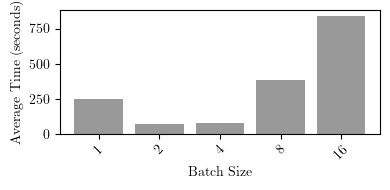

In [9]:
# Plot time deltas for each batch

# for each batch
batch_deltas = {}
for i, (batch_name, data) in enumerate(batch_data.items()):
    
    # for each trial extract the iteration number with the best throughput
    best_iterations = {}
    for trial_name, trial_df in data["trial_data"].items():
        # extract the trial index from the trial_df
        best_per_trial = (
            trial_df
            .groupby("trial_index")["inv_rho_inc"]
            .max()
            .reset_index()
        )
        # get the iteration number with the best throughput
        best_iteration = best_per_trial.loc[best_per_trial['inv_rho_inc'].idxmax(), 'trial_index']
        best_iterations[trial_name] = best_iteration

    # extract the timestamps for the best iteration
    timestamps_df = data["timestamps_data"]

    deltas = []
    for trial_name, best_iteration in best_iterations.items():
        end_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == best_iteration, 'timestamp']
        start_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == 0, 'timestamp']

        if end_timestamp.empty or start_timestamp.empty:
            print(f"  {trial_name}: No timestamp found for best iteration {best_iteration}")
            continue
        
        delta = pd.to_datetime(end_timestamp.values[0]) - pd.to_datetime(start_timestamp.values[0])
        deltas.append(delta.total_seconds())

    # add the deltas to the batch_deltas list
    batch_deltas[batch_name] = {
        "deltas": deltas,
        "average": np.mean(deltas),
        "batch_size": data['batch'],
    }

# plot a bar chart of the deltas (average time taken for each batch)
plt.figure(figsize=(4, 2))
plt.bar([d['batch_size'] for d in batch_deltas.values()], [d['average'] for d in batch_deltas.values()], color='black', alpha=0.4)
plt.xlabel('Batch Size')
plt.ylabel('Average Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}batch_deltas.pdf", bbox_inches='tight')

In [10]:
# Load skew data

skew_dir = "../data/outer/skew"
skew_data = {}

# for each folder in the batch directory
for folder in os.listdir(skew_dir):
    folder_path = os.path.join(skew_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": 8,
            "iteration": 20,
            "runs": 10,
            "timestamps_data": {},
            "trial_data": {},
            "skew_range": (float(folder_name_parts[1]), float(folder_name_parts[2]))
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the skew_data dictionary
        skew_data[folder] = data

In [11]:
# Print root elements of skew_data
for key, value in skew_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}, Skew Range: {value['skew_range']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

skew_-3.0_3.0: 8, 20, 10, Skew Range: (-3.0, 3.0)
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

skew_-5.0_5.0: 8, 20, 10, Skew Range: (-5.0, 5.0)
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

skew_-1.0_1.0: 8, 20, 10, Skew Range: (-1.0, 1.0)
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']



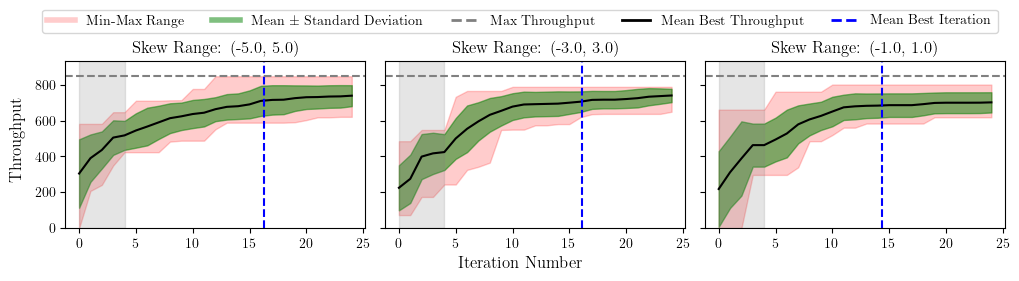

In [12]:
# Plot each skew in a separate subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the skew_data by the lower bound of skew_range
skew_data = dict(sorted(skew_data.items(), key=lambda item: item[1]['skew_range'][0]))

max_rho = 0.0

for i, (name, data) in enumerate(skew_data.items()):
    ax = axes[i]

    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current max is greater
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')

    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )

    ax.set_title(f"Skew Range: {data['skew_range']}")
    ax.axvspan(0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)

# shared axis labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}skew_error_area.pdf", bbox_inches='tight')


In [14]:
# Load skew data
island_dir = "../data/outer/island"
island_data = {}

# for each folder in the batch directory
for folder in os.listdir(island_dir):
    folder_path = os.path.join(island_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": 8,
            "iteration": 20,
            "runs": 10,
            "timestamps_data": {},
            "trial_data": {},
            "num_islands": int(folder_name_parts[3]),
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the island_data dictionary
        island_data[folder] = data

In [15]:
# Print root elements of island_data
for key, value in island_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}, Num Islands: {value['num_islands']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

min_island_size_4: 8, 20, 10, Num Islands: 4
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

min_island_size_2: 8, 20, 10, Num Islands: 2
Timestamps data: ['4', '3', '2', '5', '1', '6']
Trial data: ['6', '4', '5', '1', '2', '3']

min_island_size_16: 8, 20, 10, Num Islands: 16
Timestamps data: ['4', '3', '2', '5', '1', '6']
Trial data: ['6', '4', '5', '1', '2', '3']

min_island_size_8: 8, 20, 10, Num Islands: 8
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']



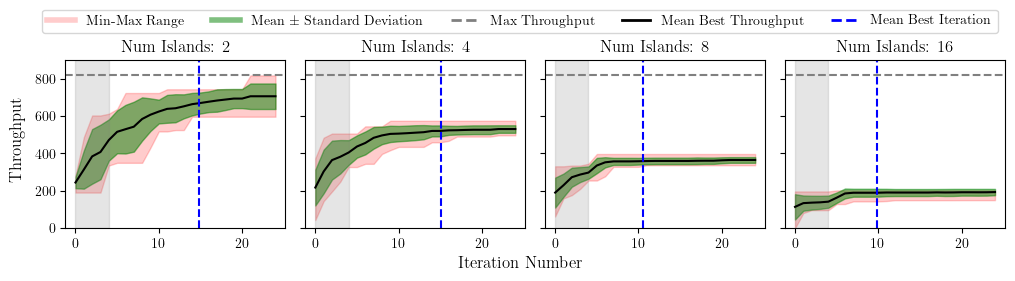

In [16]:
# Plot each island in a separate subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the island_data by num_islands
island_data = dict(sorted(island_data.items(), key=lambda item: item[1]['num_islands']))

max_rho = 0.0

for i, (name, data) in enumerate(island_data.items()):
    ax = axes[i]

    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current max is greater
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')

    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )

    ax.set_title(f"Num Islands: {data['num_islands']}")
    ax.axvspan(0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes.flat:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)

# shared axis labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}island_error_area.pdf", bbox_inches='tight')

In [17]:
# Load old saasbo data

old_saasbo_dir = "../data/outer/old-saasbo"
old_saasbo_data = {}

# for each folder in the batch directory
for folder in os.listdir(old_saasbo_dir):
    folder_path = os.path.join(old_saasbo_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": folder_name_parts[1],
            "iteration": folder_name_parts[2],
            "runs": folder_name_parts[3],
            "timestamps_data": {},
            "trial_data": {}
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the old_saasbo_data dictionary
        old_saasbo_data[folder] = data

In [18]:
# print root elements of old_saasbo_data
for key, value in old_saasbo_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

saasbo_8_10_5: 8, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_4_10_5: 4, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_2_10_5: 2, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']



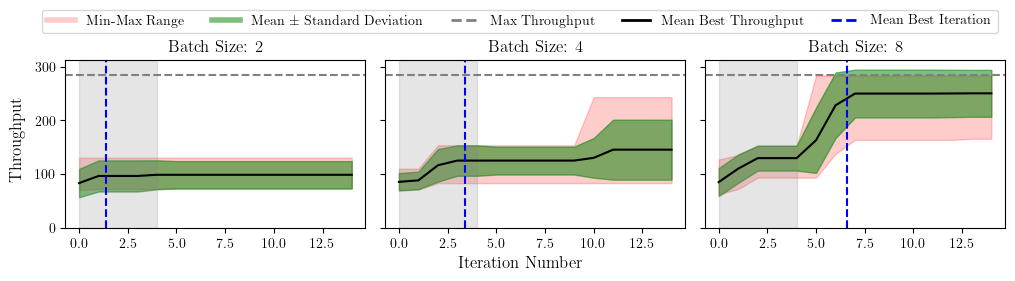

In [19]:
# Plot each old_saasbo_data in a subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

# Create a subplot
fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the old_saasbo_data by int
old_saasbo_data = dict(sorted(old_saasbo_data.items(), key=lambda item: int(item[1]['batch'])))

# find the maximum inv_rho_inc across all trials and batches
max_rho = 0.0

for i, (batch_name, data) in enumerate(old_saasbo_data.items()):
    ax = axes[i]

    # concatenate all trials, then compute mean and std of inv_rho_inc by trial_index
    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current batch has a higher max inv_rho_inc
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')
    
    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )
    
    ax.set_title(f"Batch Size: {data['batch']}")

    # Shade warmup trials 0-4
    ax.axvspan(0.0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)  # set y-limits to 10% above max_rho

# shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_error_area.pdf", bbox_inches='tight')

  4: No timestamp found for best iteration 4
  5: No timestamp found for best iteration 1
  1: No timestamp found for best iteration 1
  2: No timestamp found for best iteration 1
  4: No timestamp found for best iteration 2
  5: No timestamp found for best iteration 3
  3: No timestamp found for best iteration 2


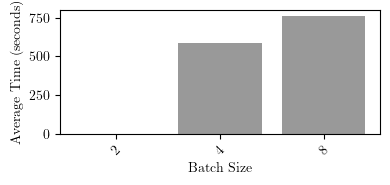

In [20]:
# Plot time deltas for each batch

# for each batch
batch_deltas = {}
for i, (batch_name, data) in enumerate(old_saasbo_data.items()):
    
    # for each trial extract the iteration number with the best throughput
    best_iterations = {}
    for trial_name, trial_df in data["trial_data"].items():
        # extract the trial index from the trial_df
        best_per_trial = (
            trial_df
            .groupby("trial_index")["inv_rho_inc"]
            .max()
            .reset_index()
        )
        # get the iteration number with the best throughput
        best_iteration = best_per_trial.loc[best_per_trial['inv_rho_inc'].idxmax(), 'trial_index']
        best_iterations[trial_name] = best_iteration

    # extract the timestamps for the best iteration
    timestamps_df = data["timestamps_data"]

    deltas = []
    for trial_name, best_iteration in best_iterations.items():
        end_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == best_iteration, 'timestamp']
        start_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == 0, 'timestamp']

        if end_timestamp.empty or start_timestamp.empty:
            print(f"  {trial_name}: No timestamp found for best iteration {best_iteration}")
            continue
        
        delta = pd.to_datetime(end_timestamp.values[0]) - pd.to_datetime(start_timestamp.values[0])
        deltas.append(delta.total_seconds())

    # add the deltas to the batch_deltas list
    batch_deltas[batch_name] = {
        "deltas": deltas,
        "average": np.mean(deltas),
        "batch_size": data['batch'],
    }

# plot a bar chart of the deltas (average time taken for each batch)
plt.figure(figsize=(4, 2))
plt.bar([d['batch_size'] for d in batch_deltas.values()], [d['average'] for d in batch_deltas.values()], color='black', alpha=0.4)
plt.xlabel('Batch Size')
plt.ylabel('Average Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_deltas.pdf", bbox_inches='tight')

In [21]:
# Load saasbo kslots data

old_saasbo_kslots_dir = "../data/outer/old-saasbo-kslots"
old_saasbo_kslots_data = {}

# for each folder in the batch directory
for folder in os.listdir(old_saasbo_kslots_dir):
    folder_path = os.path.join(old_saasbo_kslots_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": 4,
            "iteration": 10,
            "runs": 5,
            "timestamps_data": {},
            "trial_data": {},
            "kslots": folder_name_parts[3],
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the old_saasbo_data dictionary
        old_saasbo_kslots_data[folder] = data

In [22]:
# print root elements of old_saasbo_kslots_data
for key, value in old_saasbo_kslots_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}, {value['kslots']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

saasbo_k_slots_16: 4, 10, 5, 16
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_k_slots_32: 4, 10, 5, 32
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_k_slots_8: 4, 10, 5, 8
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']



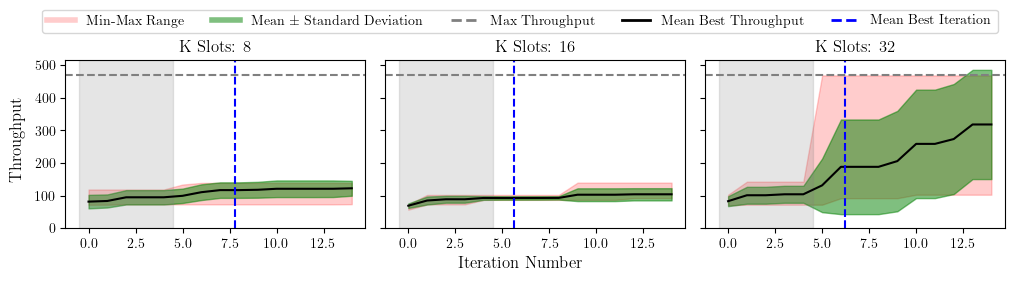

In [23]:
# Plot each kslots in a subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the old_saasbo_kslots_data by kslots
old_saasbo_kslots_data = dict(sorted(old_saasbo_kslots_data.items(), key=lambda item: int(item[1]['kslots'])))

# find the maximum inv_rho_inc across all trials and batches
max_rho = 0.0

for i, (name, data) in enumerate(old_saasbo_kslots_data.items()):
    ax = axes[i]

    # concatenate all trials, then compute mean and std of inv_rho_inc by trial_index
    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current batch has a higher max inv_rho_inc
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')
    
    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )
    
    ax.set_title(f"K Slots: {data['kslots']}")

    # Shade warmup trials 0-4
    ax.axvspan(-0.5, 4.5, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)  # set y-limits to 10% above max_rho

# shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_kslots_error_area.pdf", bbox_inches='tight')

  5: No timestamp found for best iteration 2
  2: No timestamp found for best iteration 4
  3: No timestamp found for best iteration 1


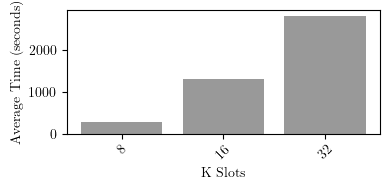

In [24]:
# Plot time deltas for each kslots

# for each kslots
kslots_deltas = {}

for i, (name, data) in enumerate(old_saasbo_kslots_data.items()):
    # for each trial extract the iteration number with the best throughput
    best_iterations = {}
    for trial_name, trial_df in data["trial_data"].items():
        # extract the trial index from the trial_df
        best_per_trial = (
            trial_df
            .groupby("trial_index")["inv_rho_inc"]
            .max()
            .reset_index()
        )
        # get the iteration number with the best throughput
        best_iteration = best_per_trial.loc[best_per_trial['inv_rho_inc'].idxmax(), 'trial_index']
        best_iterations[trial_name] = best_iteration

    # extract the timestamps for the best iteration
    timestamps_df = data["timestamps_data"]

    deltas = []
    for trial_name, best_iteration in best_iterations.items():
        end_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == best_iteration, 'timestamp']
        start_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == 0, 'timestamp']

        if end_timestamp.empty or start_timestamp.empty:
            print(f"  {trial_name}: No timestamp found for best iteration {best_iteration}")
            continue
        
        delta = pd.to_datetime(end_timestamp.values[0]) - pd.to_datetime(start_timestamp.values[0])
        deltas.append(delta.total_seconds())

    # add the deltas to the kslots_deltas list
    kslots_deltas[name] = {
        "deltas": deltas,
        "average": np.mean(deltas),
        "kslots": data['kslots'],
    }
    
# plot a bar chart of the deltas (average time taken for each kslots)
plt.figure(figsize=(4, 2))
plt.bar([d['kslots'] for d in kslots_deltas.values()], [d['average'] for d in kslots_deltas.values()], color='black', alpha=0.4)
plt.xlabel('K Slots')
plt.ylabel('Average Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_kslots_deltas.pdf", bbox_inches='tight')